In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf 
import matplotlib.pyplot as plt 
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as ssim

In [2]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, embedding_size = 64, omega = 10, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.embedding_size = embedding_size
        self.omega = omega
    def build(self, input_shape):
        # Called once input shape is known
        self.input_dim = input_shape[-1]
        self.output_dim = self.input_dim * 2 * self.embedding_size
    def call(self, inputs):
        x = inputs
        omega = tf.cast(self.omega, dtype = tf.float32)
        batch_size = tf.shape(x)[0]
        dim = tf.shape(x)[1]
        j = tf.range(self.embedding_size, dtype = tf.float32)
        j = j/tf.cast(self.embedding_size, dtype = tf.float32)
        freq = 2.0 * np.pi * tf.pow(omega, j)
        x_exp = tf.expand_dims(x, -1)
        x_scaled = x_exp * freq
        sin_scaled = tf.sin(x_scaled)
        cos_scaled = tf.cos(x_scaled)
        sin_cos = tf.concat([cos_scaled, sin_scaled], axis = -1)
        sin_cos_flattend = tf.reshape(sin_cos, (batch_size, -1))
        encoded = tf.concat([x, sin_cos_flattend], axis = -1)
        return encoded
    def compute_output_shape(self, input_shape):
        input_dim = input_shape[-1]
        out_dim = input_dim + (input_dim * 2 * self.embedding_size)
        return (input_shape[0], out_dim)

In [3]:
class Trident(tf.keras.layers.Layer):
    def __init__(self, out_features, is_first = False, s = 5, **kwargs):
        super(Trident, self).__init__(**kwargs)
        self.out_features = out_features
        self.is_first = is_first
        self.s = s
    def build(self, input_shape):
        in_features = input_shape[-1]
        if self.is_first:
            limit = 1/in_features
        else:
            limit = np.sqrt(6/in_features)/self.s
        self.w = self.add_weight(shape = (in_features, self.out_features), initializer = tf.keras.initializers.RandomUniform(minval = -limit, maxval = limit), trainable = True, name = 'weights')
        self.b = self.add_weight(shape = (self.out_features, ), initializer = tf.keras.initializers.Zeros(), trainable = True, name = 'bias')
    def call(self, inputs):
        x = tf.linalg.matmul(inputs, self.w)
        x += self.b
        a = self.s * tf.pow(x, 2)
        return tf.exp(-a)

In [7]:
def build_model(input_features, out_features, embedding_size = 50, omega_pe = 10, hidden_features = 256, hidden_layers = 5):
    input_img = tf.keras.Input(shape = (input_features, ))
    PE = PositionalEncoding(embedding_size, omega_pe)(input_img)
    x = tf.keras.layers.Dense(hidden_features, activation = 'relu')(PE)
    for i in range(hidden_layers-1):
        x = tf.keras.layers.Dense(hidden_features, activation = 'relu')(x)
    Outputs = tf.keras.layers.Dense(out_features, activation = 'tanh')(x)
    model = tf.keras.Model(inputs = input_img, outputs = Outputs)
    return model

In [9]:
def Trident_model(in_features, out_features, embedding_size = 50, s = 5, omega_pe = 10, hidden_features = 256, hidden_layers = 2, outermost_linear = False):
    input_img = tf.keras.Input(shape = (in_features, ))
    PE = PositionalEncoding(embedding_size, omega_pe)(input_img)
    x = Trident(out_features = hidden_features, is_first = True, s = s)(PE)
    for i in range(hidden_layers-1):
        x = Trident( out_features = hidden_features, is_first = False, s = s)(x)
    if outermost_linear:
        output = tf.keras.layers.Dense(out_features, activation = 'tanh')(x)
    else:
        output = Trident(out_features = out_features, is_first = False, s = s)(x)
    model = tf.keras.Model(inputs = input_img, outputs = output)
    return model

In [11]:
Model_pe = build_model(input_features = 2, out_features = 3, hidden_layers = 5, omega_pe = 20)
Model_pe.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_encoding             │ (None, 202)            │             0 │
│ (PositionalEncoding)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        51,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 315,907 (1.21 MB)

 Trainable params: 315,907 (1.21 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
Trident1 = Trident_model(in_features =2, out_features = 3, s = 5, omega_pe = 20, hidden_layers = 5, outermost_linear = True)
Trident1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_encoding_1           │ (None, 202)            │             0 │
│ (PositionalEncoding)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ trident (Trident)               │ (None, 256)            │        51,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ trident_1 (Trident)             │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ trident_2 (Trident)             │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ trident_3 (Trident)             │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ trident_4 (Trident)             │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 315,907 (1.21 MB)

 Trainable params: 315,907 (1.21 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
def mgrid(len, dim = 2):
    t = []
    for i in range(dim):
        lin = tf.linspace(-1, 1, len)
        t.append(lin)
    mesh = tf.meshgrid(*t, indexing = "ij")
    mgrid = tf.stack(mesh, axis = -1)
    mgrid = tf.reshape(mgrid, [-1,dim])
    return mgrid

In [17]:
import os 
from PIL import Image 
def bsds_tensor(sidelength, split = 'test', ids = '108005', bsds_dir = "C:/Users/HP/Downloads/summer project/archive (1)/BSDS300/BSDS300/images"):
    filepath = os.path.join(bsds_dir, split, f'{ids}.jpg')
    img = Image.open(filepath).convert('RGB')
    img = tf.convert_to_tensor(np.array(img)/255, dtype = tf.float32)
    #img_new = tf.image.resize(img, size=(sidelength,sidelength), method="bicubic").numpy()
    height, width = tf.shape(img)[0], tf.shape(img)[1]
    crop_x = (height - sidelength) // 2
    crop_y = (width - sidelength) // 2
    img_cropped = img[crop_x:crop_x+sidelength, crop_y:crop_y+sidelength, :]
    return img_cropped

In [19]:
def noisy_image(img, sigma):
    noise = tf.random.normal(shape = tf.shape(img), mean = 0, stddev = sigma, dtype = img.dtype)
    img_noisy = tf.clip_by_value(img + noise, clip_value_min = 0, clip_value_max = 1)
    return tf.cast(img_noisy, tf.float32)

In [21]:
def ImageFitting(sidelength, split = 'test', ids = '108005', bsds_dir = "C:/Users/HP/Downloads/summer project/archive (1)/BSDS300/BSDS300/images", noisy = False, sigma = 0.1):
    clean_img = bsds_tensor(sidelength, split, ids, bsds_dir)
    coords = mgrid(sidelength)
    if noisy: 
        img_noise = noisy_image(clean_img, sigma)
        pixels = tf.reshape(img_noise, [-1,3])
        dataset = tf.data.Dataset.from_tensor_slices((coords, pixels))
        dataset = dataset.batch(sidelength * sidelength, drop_remainder = True)
        return dataset, clean_img
    else:
        pixels = tf.reshape(clean_img, [-1,3])
        return coords, clean_img, pixels

In [23]:
#super resolution
def training_model_sr(sidelength, model, split = 'test', ids = '108005', epochs = 100):
    coords, img_clean, pixels = ImageFitting(sidelength, split = split, ids = ids)
    img_clean = np.array(img_clean, dtype=np.float32)
    model.compile(optimizer = tf.keras.optimizers.Adam(1e-4), loss = 'mse')
    model.fit(coords, pixels, batch_size = 1024, epochs = epochs, verbose = 1)
    return img_clean, model

In [25]:
def super_resolve(model, times, in_dim):
    H_hr = times * in_dim
    coords_hr = mgrid(H_hr)
    prediction = model.predict(coords_hr, batch_size =1024)
    #prediction = tf.clip_by_value(prediction, 0., 1.)
    sr_img = tf.reshape(prediction, [H_hr, H_hr, 3])
    return sr_img.numpy()

Epoch 1/400
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - loss: 0.0580
Epoch 2/400
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0304
Epoch 3/400
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0251
Epoch 4/400
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0222
Epoch 5/400
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - loss: 0.0199
Epoch 6/400
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - loss: 0.0174
Epoch 7/400
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - loss: 0.0161
Epoch 8/400
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - loss: 0.0150
Epoch 9/400
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - loss: 0.0139
Epoch 10/400
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0130
Epoch 11/400
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0120
Epoch 12/400
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0112
Epoch 13/400
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - loss: 0.0109
Epoch 14/400
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0100
Epoch 15/400
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/

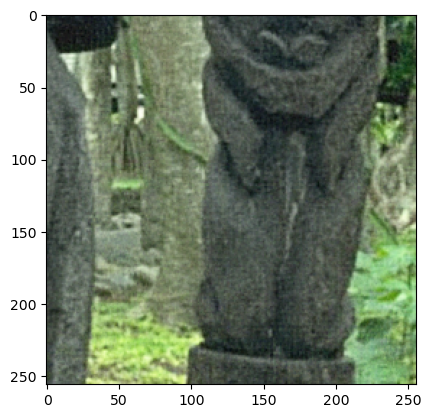

In [27]:
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
ground_truth, PE_model = training_model_sr(128, Model_pe, ids = '101085', epochs = 400)
clean_resized = tf.image.resize(ground_truth, size=(128 * 2,128 * 2), method="bicubic").numpy()
sr_image = super_resolve(PE_model, 2, 128)
sr_image_scaled = (sr_image - sr_image.min())/(sr_image.max() - sr_image.min())
plt.imshow(sr_image_scaled)
clean_resized = (clean_resized - clean_resized.min())/(clean_resized.max() - clean_resized.min())
psnr = compare_psnr(clean_resized, sr_image_scaled)

In [29]:
# Positional Encoding Results for Super Resolution
from skimage.metrics import structural_similarity as ssim
ssim_value = ssim(clean_resized, sr_image_scaled, data_range = 1, win_size = 3)
print("SSIM for Positional Encoding Model:", ssim_value)
print("psnr for Positional Encoding Model:", psnr)

SSIM for Positional Encoding Model: 0.8577301324852522
psnr for Positional Encoding Model: 24.111849477179476


Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0660
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0330
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0289
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0277
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0268
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0238
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0179
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0143
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0131
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0129
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0118
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0112
Epoch 13/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0104
Epoch 14/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0101
Epoch 15/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - lo

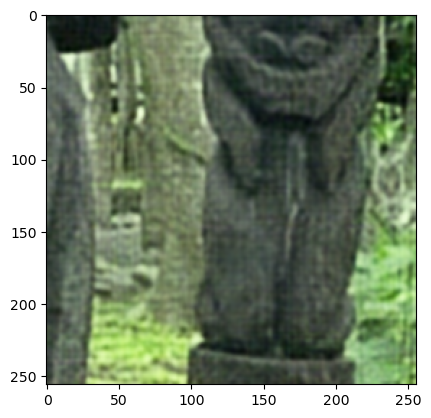

In [31]:
#Trident Model Super Resolution
ground_truth, PE_model2 = training_model_sr(128, Trident1,ids = '101085', epochs = 100)
clean_resized = tf.image.resize(ground_truth, size=(128 * 2,128 * 2), method="bicubic").numpy()
sr_image2 = super_resolve(PE_model2, 2, 128)
sr_image_scaled2 = (sr_image2 - sr_image2.min())/(sr_image2.max() - sr_image2.min())
plt.imshow(sr_image_scaled2)
clean_resized = (clean_resized - clean_resized.min())/(clean_resized.max() - clean_resized.min())
psnr2 = compare_psnr(clean_resized, sr_image_scaled2)

In [33]:
# Trident Model Results for Super Resolution
ssim_value2 = ssim(clean_resized, sr_image_scaled2, data_range = 1, win_size = 3)
print("SSIM:", ssim_value2)
print("psnr:", psnr2)

SSIM: 0.8763258232452104
psnr: 24.80303299516915


In [35]:
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
def training_model_denoising(sidelength, model, s = "test", ids = "108005", sigma = 0.1, total_steps = 600):
    dataloader, img_clean = ImageFitting(sidelength, split = s, ids = ids, sigma = sigma, noisy = True)
    img_clean = np.array(img_clean, dtype=np.float32)
    img_clean = (img_clean - img_clean.min())/(img_clean.max() - img_clean.min())
    model_input, ground_truth = next(iter(dataloader))
    img_in = tf.reshape(ground_truth, (sidelength,sidelength,3)).numpy()
    
    optimizer = tf.keras.optimizers.Adam(1e-4)
    
    psnr_cleans = []
    best_psnr_clean, best_step = -np.inf, 0
    
    for step in range(total_steps + 1):
        with tf.GradientTape() as tape:
            model_output = model(model_input, trainig = True)
            loss = tf.reduce_mean((model_output - ground_truth) ** 2)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        img_out = np.array(tf.reshape(model_output, (sidelength, sidelength, 3)).numpy(), dtype=np.float32)
        psnr = compare_psnr(img_clean, img_out)
        psnr_cleans.append(psnr)
        if psnr>best_psnr_clean:
            best_psnr_clean = psnr
            best_step = step
        if step % 20 == 0:
            print(f"step {step}, loss:{loss.numpy():.6f}, psnr_clean:{psnr:.2f}")
    
    img_out_scaled = (img_out - img_out.min()) / (img_out.max() - img_out.min())
    img_in_scaled = (img_in - img_in.min())/(img_in.max() - img_in.min())
    fig,axs = plt.subplots(1,3, figsize = (15,5))
    axs[0].imshow(img_out_scaled); axs[0].set_title("Model Output")
    axs[1].imshow(img_in_scaled); axs[1].set_title("Noisy Input")
    axs[2].imshow(img_clean); axs[2].set_title("Clean Image")
    plt.show()
    return psnr_cleans, img_out_scaled



In [89]:
Trident2 = Trident_model(in_features =2, out_features = 3, s = 5,hidden_layers = 5, omega_pe = 7, outermost_linear = True)
Trident2.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_encoding_6           │ (None, 202)            │             0 │
│ (PositionalEncoding)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ trident_15 (Trident)            │ (None, 256)            │        51,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ trident_16 (Trident)            │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ trident_17 (Trident)            │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ trident_18 (Trident)            │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ trident_19 (Trident)            │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 315,907 (1.21 MB)

 Trainable params: 315,907 (1.21 MB)

 Non-trainable params: 0 (0.00 B)

step 0, loss:0.388335, psnr_clean:4.20
step 20, loss:0.050094, psnr_clean:13.75
step 40, loss:0.037989, psnr_clean:15.29
step 60, loss:0.036123, psnr_clean:15.56
step 80, loss:0.033987, psnr_clean:15.92
step 100, loss:0.027612, psnr_clean:17.19
step 120, loss:0.022429, psnr_clean:18.62
step 140, loss:0.020464, psnr_clean:19.27
step 160, loss:0.018736, psnr_clean:19.95
step 180, loss:0.016969, psnr_clean:20.78
step 200, loss:0.015404, psnr_clean:21.66
step 220, loss:0.014461, psnr_clean:22.28
step 240, loss:0.014089, psnr_clean:22.49
step 260, loss:0.013741, psnr_clean:22.74
step 280, loss:0.013419, psnr_clean:23.02
step 300, loss:0.013164, psnr_clean:23.19
step 320, loss:0.012953, psnr_clean:23.32
step 340, loss:0.012748, psnr_clean:23.49
step 360, loss:0.012629, psnr_clean:23.59
step 380, loss:0.012411, psnr_clean:23.73
step 400, loss:0.012254, psnr_clean:23.82
step 420, loss:0.012536, psnr_clean:23.43
step 440, loss:0.012008, psnr_clean:24.02
step 460, loss:0.011900, psnr_clean:24.07

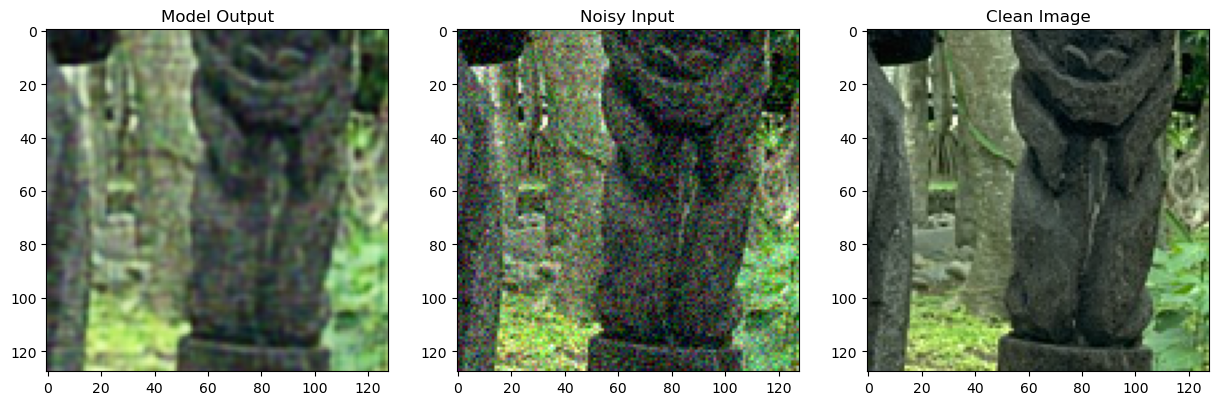

In [91]:
psnr_denoising1, image_output1 = training_model_denoising(sidelength = 128, model = Trident2, ids="101085", sigma =0.1, total_steps = 800)

In [93]:
# Trident Model Results for Image Denoising 
image = bsds_tensor(sidelength = 128, split = 'test', ids = '101085')
image = image.numpy()
image_output1 = image_output1.astype(np.float32)
ssim_value3 = ssim(image, image_output1, data_range = 1, win_size = 3)
print("PSNR:", psnr_denoising1[-1])
print("SSIM:", ssim_value3)

PSNR: 24.777838765956428
SSIM: 0.6874309698689484


In [77]:
Model_pe2 = build_model(input_features = 2, out_features = 3, omega_pe = 7, hidden_layers = 5)
Model_pe2.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_encoding_4           │ (None, 202)            │             0 │
│ (PositionalEncoding)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │        51,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 315,907 (1.21 MB)

 Trainable params: 315,907 (1.21 MB)

 Non-trainable params: 0 (0.00 B)

step 0, loss:0.090528, psnr_clean:10.90
step 20, loss:0.034701, psnr_clean:15.80
step 40, loss:0.028084, psnr_clean:17.03
step 60, loss:0.023676, psnr_clean:18.13
step 80, loss:0.020924, psnr_clean:18.98
step 100, loss:0.018867, psnr_clean:19.72
step 120, loss:0.017127, psnr_clean:20.46
step 140, loss:0.015673, psnr_clean:21.17
step 160, loss:0.014533, psnr_clean:21.81
step 180, loss:0.013653, psnr_clean:22.33
step 200, loss:0.012964, psnr_clean:22.76
step 220, loss:0.012404, psnr_clean:23.10
step 240, loss:0.011930, psnr_clean:23.39
step 260, loss:0.011517, psnr_clean:23.64
step 280, loss:0.011147, psnr_clean:23.85
step 300, loss:0.010811, psnr_clean:24.04
step 320, loss:0.010499, psnr_clean:24.20
step 340, loss:0.010209, psnr_clean:24.35
step 360, loss:0.009937, psnr_clean:24.48
step 380, loss:0.009679, psnr_clean:24.60
step 400, loss:0.009433, psnr_clean:24.71
step 420, loss:0.009198, psnr_clean:24.80
step 440, loss:0.008971, psnr_clean:24.88
step 460, loss:0.008754, psnr_clean:24.9

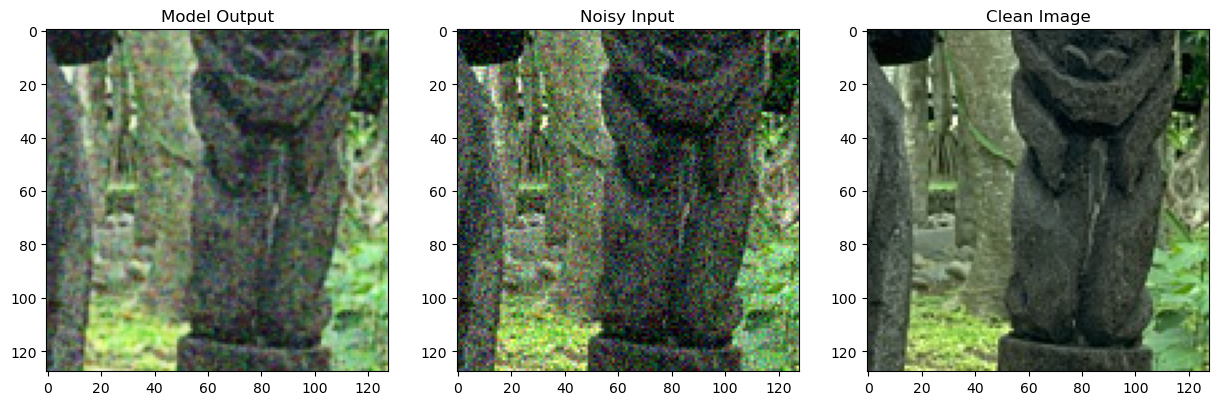

In [79]:
psnr_denoising2, image_output2 = training_model_denoising(sidelength = 128, model = Model_pe2, ids="101085", sigma =0.1, total_steps = 800)

In [81]:
image = bsds_tensor(sidelength = 128, split = 'test', ids = '101085')
image = image.numpy()
image_output2 = image_output2.astype(np.float32)
ssim_value4 = ssim(image, image_output2, data_range = 1, win_size = 3)
print("PSNR:", psnr_denoising2[-1])
print("SSIM:", ssim_value4)

PSNR: 24.903203342502405
SSIM: 0.6746360374982816
